In [1]:
import numpy as np
from Utils import optimizer_utils as ou
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import os


# Define measurement data, camera, and beam energy
# params = {
#     'data':'../Scans/2024-08-09/Quadscan.csv',
#     'camera':'cam4',
#     'energy':80e6,
# }

params = {
    'data':'../Scans/2024-08-13/Quadscan.csv',
    'camera':'cam5',
    'energy':80e6,
}

# Thresholds
std_threshold = 100 # remove datapoint if std>thresh
Q2_threshold = 1 # Remove datapoint if abs(Q2)<thresh


In [2]:

# Read data, apply calibration
if os.path.isdir(params['data']):
    df = ou.merge_csvs(params['data'])
else:
    df = pd.read_csv(params['data'])

# Scale by calibration
df.xrms *= df.calibration
df.yrms *= df.calibration

# Group on quad currents for mean and std
grouped = df.groupby(['Q1', 'Q2', 'Q3'])
xdf = grouped.agg(
    spotsize_mean=('xrms', 'mean'),
    spotsize_std=('xrms', 'std'),
    ).reset_index()

ydf = grouped.agg(
    spotsize_mean=('yrms', 'mean'),
    spotsize_std=('yrms', 'std'),
    ).reset_index()

# Flip currents for y
ydf[['Q1', 'Q2', 'Q3']] = -1*ydf[['Q1', 'Q2', 'Q3']] 

# Remove datasets with std above threshold
xdf = xdf[xdf.spotsize_std<std_threshold]
ydf = ydf[ydf.spotsize_std<std_threshold]

# Remove datasets far from focus
xdf = xdf[xdf.Q2.abs()>Q2_threshold]
ydf = ydf[ydf.Q2.abs()>Q2_threshold]



----- X Optimization -----
Optimized = [ 1.7564857  -0.66506603  0.9316932 ]
Emittance: 9.32e-08
Norm. Emittance: 1.46e-05
Beta Twiss: 1.76
Alpha Twiss: -0.67
----- Y Optimization -----
Optimized = [ 1.45942269 -0.08713546  0.50709064]
Emittance: 5.07e-08
Norm. Emittance: 7.94e-06
Beta Twiss: 1.46
Alpha Twiss: -0.09


Text(0.5, 1.0, 'Quad Scan Optimization')

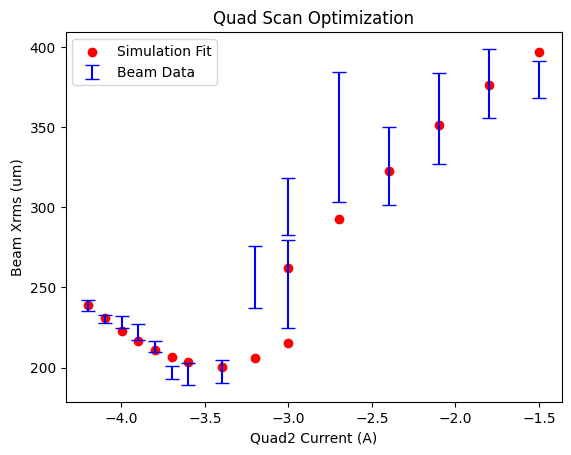

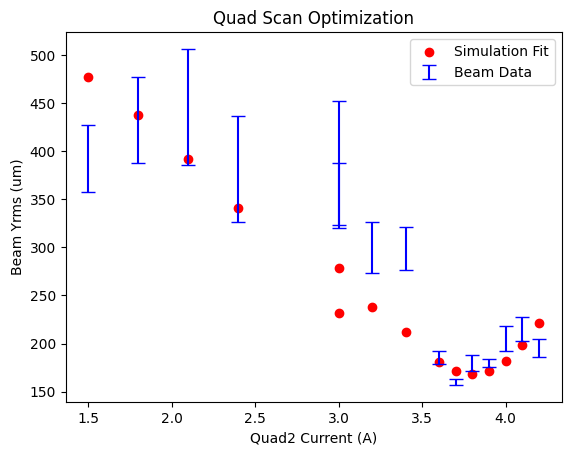

In [4]:
# Run optimizer (emittance scaled by 1e8)
bounds = [(0.1, 10), (-5, 5), (.01, 5)] 
x0 = [1, 0, .5]

def run_optimizer(df):
    opt_fcn = lambda x: ou.errorfcn(x, df, params['energy'], params['camera'])
    result = minimize(opt_fcn, x0, method='L-BFGS-B', bounds=bounds)
    
    ou.print_results(result.x, params['energy'])

    _, ax = ou.plot_fit_vs_data(result.x, df, params['energy'], params['camera'])
    return ax

print('----- X Optimization -----')
ax = run_optimizer(xdf)
ax.set_xlabel('Quad2 Current (A)')
ax.set_ylabel('Beam Xrms (um)')
ax.set_title('Quad Scan Optimization')


print('----- Y Optimization -----')
ax = run_optimizer(ydf)
ax.set_xlabel('Quad2 Current (A)')
ax.set_ylabel('Beam Yrms (um)')
ax.set_title('Quad Scan Optimization')
